In [ ]:
'''
1.ライブラリのインポート
'''

import numpy as np
import matplotlib.pyplot as plt
import time
from copy import copy

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# import qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import *

from qiskit_aer import AerSimulator
from qiskit.circuit.library import U3Gate
from qiskit import transpile

In [ ]:
'''
2.QMLCircuit 
このクラスは量子回路を構築・実行するためのクラスです。
・__init__()（コンストラクタ）
  ・n_qubits: 使用する量子ビットの数。
  ・回路の構造は以下の通り：
    ・各量子ビットに対して U ゲートを適用。
    ・各ビットに隣接する制御付きU3ゲート（制御ゲート）を適用。
    ・最後に最終ビットに U ゲート。
  ・測定は行わず、状態ベクトルを取得。

・run() メソッド
  与えられたデータとパラメータで量子回路を走らせ、期待値を返す関数。
  ・amplitude_embedding(data) を使ってデータを量子状態に埋め込む。
  ・初期化回路とパラメタライズド回路を合成。
  ・statevector を保存し、期待値（最終ビットが 1 になる確率）を計算。

・amplitude_embedding()
  データを正規化して、量子状態（状態ベクトル）として使える形式に変換します。
'''

class QMLCircuit: # 全体的に修正
    def __init__(self, n_qubits, backend):
        # 学習用量子回路の作成
        self._circuit = qiskit.QuantumCircuit(n_qubits, 1)
        self.n_params = 3 * (2 * n_qubits + 1)
        self.n_qubits = n_qubits # 使用する量子ビットの数。
        self.all_qubits = [i for i in range(n_qubits)]
        self.params = [qiskit.circuit.Parameter(f'p{i}') for i in range(self.n_params)]
        
        # 各量子ビットにUゲート適用
        for qubit in self.all_qubits:
            self._circuit.u(self.params[3 * qubit],
                            self.params[3 * qubit + 1],
                            self.params[3 * qubit + 2], qubit)
        self._circuit.barrier()
        
        # cu3の代替：制御付きU3ゲートを使う
        for qubit in self.all_qubits:
            control = qubit
            target = (qubit + 1) % n_qubits

            theta = self.params[3 * n_qubits + 3 * qubit]
            phi   = self.params[3 * n_qubits + 3 * qubit + 1]
            lam   = self.params[3 * n_qubits + 3 * qubit + 2]

            controlled_u3 = U3Gate(theta, phi, lam).control(1)
            self._circuit.append(controlled_u3, [control, target])

        # 最後のUゲート
        self._circuit.u(self.params[-3], self.params[-2], self.params[-1], self.n_qubits - 1)

        # 測定は今回は行わない（状態ベクトル用）
        # self._circuit.measure(self.n_qubits - 1, 0)

        self.backend = backend

    def run(self, data, params):
        # パラメータを辞書に変換
        param_dict = {self.params[i]: float(params[i]) for i in range(self.n_params)}

        # データを numpy 配列に変換（torch対策）
        if isinstance(data, torch.Tensor):
            data = data.numpy()

        # 振幅エンコーディング回路の作成
        init_circ = qiskit.QuantumCircuit(self.n_qubits, 1)
        init_statevec = self.amplitude_embedding(data)
        init_circ.initialize(init_statevec, self.all_qubits)

        # 学習用テンプレート回路と合成（self._circuit はテンプレートとして不変にする）
        combined_circuit = init_circ.compose(self._circuit)

        # パラメータを代入
        bound_circuit = combined_circuit.assign_parameters(param_dict)

        # 回路に明示的な名前を付けて、Qiskit側での混乱を防止
        bound_circuit.name = f"circuit_{np.random.randint(1e6)}"

        # 状態ベクトル保存命令を追加（これがないと出力が取れない！）
        bound_circuit.save_statevector()

        # 必要！トランスパイルして実行可能な形式にする
        compiled_circuit = transpile(bound_circuit, self.backend)

        # 実行
        # job = self.backend.run(bound_circuit)
        job = self.backend.run(compiled_circuit) # ← 修正ポイント！
        result = job.result() # ← 修正ポイント！

        # 回路IDなどを指定せず、最初の実験結果のstatevectorを直接取り出す
        outputstate = result.data(0)['statevector']

        # 最終量子ビットが 1 の確率（期待値）を返す
        expectation = np.sum((np.abs(outputstate)**2)[2**(self.n_qubits - 1):])

        return np.array([expectation])


    
    def amplitude_embedding(self, data):
        # data = np.array(data, dtype = np.float)
        data = np.array(data, dtype=float)  # ← 修正ポイント！
        dim = 2 ** self.n_qubits
        if len(data) < dim:
            data = np.pad(data, (0, dim - len(data)), 'constant', constant_values=(0, 0))
        if np.sum(data**2) == 0:
            data += 1
        vec = data / np.sqrt(np.sum(data ** 2))
        return vec

Expected value 0.3923620829035644
0.08981800079345703


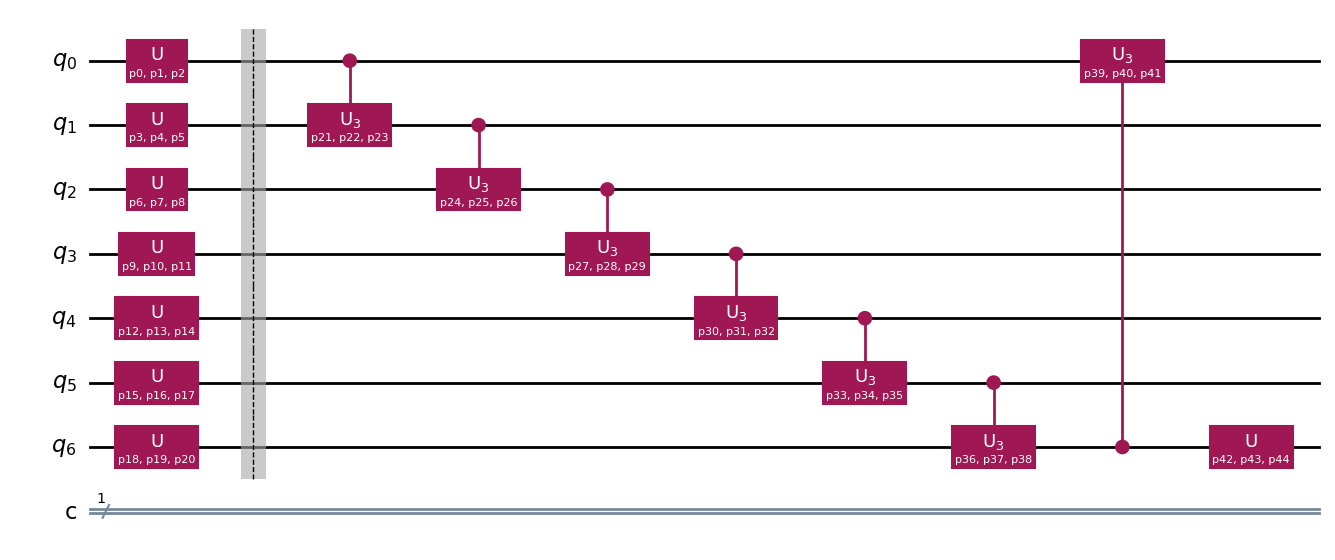

In [ ]:
'''
3.回路の実行
・7量子ビットの回路を定義。
・ランダムな2値データを用意（振幅エンコーディング用）。
・パラメータはPyTorchの Parameter として定義（後で学習できるように）。
・回路を初期化して、量子回路を走らせる。
・出力は 最終ビットが1である確率。
'''

n_qubits = 7
n_params = 3 * (2 * n_qubits + 1)
params = torch.nn.parameter.Parameter(torch.Tensor(n_params))
data = torch.Tensor(np.array([np.random.randint(0, 2) for i in range(2 ** n_qubits)]))
# simulator = qiskit.Aer.get_backend('statevector_simulator')
simulator = AerSimulator(method='statevector') # ← 修正ポイント！

start = time.time()
circuit = QMLCircuit(n_qubits, simulator)
print('Expected value {}'.format(circuit.run(data, params)[0]))
print(time.time() - start)

circuit._circuit.draw('mpl')

In [ ]:
'''
4.HybridFunction / Hybrid クラス
・HybridFunction はPyTorchの 自作Functionクラス。
  ・forward() で量子回路を使って期待値を計算。
  ・backward() でパラメータの数値勾配を計算（パラメータシフトではなく有限差分法）。
・Hybrid(nn.Module) は量子回路をレイヤーのように扱えるクラス。
'''

class HybridFunction(Function):
    
    @staticmethod
    def forward(ctx, f, data, params):
        # 順伝播の計算
        def f_each(data, params):
            return torch.tensor([f(torch.flatten(d), params) for d in data], dtype=torch.float64)
        expectation_z = f_each(data, params)
        ctx.save_for_backward(data, params, expectation_z)
        ctx.f = f_each
        return expectation_z
        
    @staticmethod
    def backward(ctx, grad_output):
        # 逆伝播の計算
        data, params, res = ctx.saved_tensors
        delta = 0.001
        gradients = []
        for i in range(len(params)):
            params[i] += delta
            gradient  = torch.sum((ctx.f(data, params) - res) / delta * grad_output)
            params[i] -= delta
            gradients.append(gradient)
        return None, None, torch.Tensor(gradients), None

class Hybrid(nn.Module):
    # 量子回路レイヤーの定義
    def __init__(self, n_qubits, backend, shots):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QMLCircuit(n_qubits, backend)
        
    def forward(self, data, params):
        def f(data, params):
            circ = copy(self.quantum_circuit)
            res = circ.run(data, params)
            return res
        return HybridFunction.apply(f, data, params)

In [ ]:
'''
5.MNISTから"0"と"1"の画像を抽出
・手書き数字データ「MNIST」から 数字0と1の画像を100枚ずつ使用。
・DataLoader を使ってバッチ化。
'''

# 学習用サンプルデータ
# MNISTから"0"と"1"を100サンプルずつ抜き出す
n_samples = 100

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=16, shuffle=True)

torch.Size([16, 1, 9, 9])


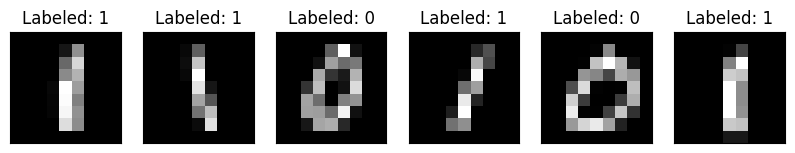

In [ ]:
'''
6.データの可視化
・抽出したMNISTの画像を平均プーリング（3×3）して小さくし、表示。
・images.shape から後段の量子回路に渡せる次元に加工確認。
'''

n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()
    images = (torch.nn.AvgPool2d(3)(images))
    axes[n_samples_show - 1].imshow(images[0][0].numpy(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets[0].item()))
    
    n_samples_show -= 1
print(images.shape)

In [ ]:
'''
7.テストデータの準備
・テスト用データも0と1をそれぞれ50枚。
・後のモデル評価に使う。
'''

n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx].float()

test_loader = torch.utils.data.DataLoader(X_test, batch_size=16, shuffle=True)

In [ ]:
'''
8.モデル定義
・Hybrid レイヤー（量子）とPyTorchの Parameter を持つシンプルなモデル。
・self.weight が学習対象の量子回路パラメータ。
'''

class Net(nn.Module):
    def __init__(self, n_qubits, n_params):
        super(Net, self).__init__()
        # self.hybrid = Hybrid(n_qubits, qiskit.Aer.get_backend('statevector_simulator'), 1)
        self.hybrid = Hybrid(n_qubits, AerSimulator(method='statevector'), 1) # ← 修正ポイント！
        self.weight = torch.nn.parameter.Parameter(torch.Tensor(n_params))
        torch.nn.init.uniform_(self.weight, 0.0, 2 * np.pi)

    def forward(self, x):
        x = self.hybrid(x, self.weight)
        return x

In [ ]:
'''
9.学習ループ
・学習回数は40エポック。
・各ミニバッチに対して：
  ・画像を量子状態に変換 → モデルに入力 → 出力とラベルでMSE計算。
  ・逆伝播で self.weight を更新。
'''

n_qubits = 7
n_params = 3 * (2 * n_qubits + 1)
model = Net(n_qubits, n_params)
optimizer = optim.Adam(model.parameters(), lr=0.02)
loss_func = nn.MSELoss()

epochs = 40
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data = (torch.nn.AvgPool2d(3)(data)).float()
        optimizer.zero_grad()
        # モデルの出力
        output = model(data)
        # 損失関数の計算
        loss = loss_func(output.squeeze(), target.double())
        # 誤差逆伝播
        loss.backward()
        # パラメータ更新
        optimizer.step()
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.1f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

/tmp/ipykernel_363/784625255.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.tensor([f(torch.flatten(d), params) for d in data], dtype=torch.float64)


Training [2.5%]	Loss: 0.2550
Training [5.0%]	Loss: 0.2317
Training [7.5%]	Loss: 0.2029
Training [10.0%]	Loss: 0.1837
Training [12.5%]	Loss: 0.1646
Training [15.0%]	Loss: 0.1494
Training [17.5%]	Loss: 0.1391
Training [20.0%]	Loss: 0.1321
Training [22.5%]	Loss: 0.1239
Training [25.0%]	Loss: 0.1151
Training [27.5%]	Loss: 0.1092
Training [30.0%]	Loss: 0.1077
Training [32.5%]	Loss: 0.1035
Training [35.0%]	Loss: 0.1027
Training [37.5%]	Loss: 0.1042
Training [40.0%]	Loss: 0.1038
Training [42.5%]	Loss: 0.1013
Training [45.0%]	Loss: 0.1038
Training [47.5%]	Loss: 0.1015
Training [50.0%]	Loss: 0.1021
Training [52.5%]	Loss: 0.1011
Training [55.0%]	Loss: 0.1020
Training [57.5%]	Loss: 0.1020
Training [60.0%]	Loss: 0.1008
Training [62.5%]	Loss: 0.1014
Training [65.0%]	Loss: 0.1013
Training [67.5%]	Loss: 0.1000
Training [70.0%]	Loss: 0.0989
Training [72.5%]	Loss: 0.0997
Training [75.0%]	Loss: 0.0993
Training [77.5%]	Loss: 0.0965
Training [80.0%]	Loss: 0.0961
Training [82.5%]	Loss: 0.0961
Training [85.

Text(0, 0.5, 'MSE Loss')

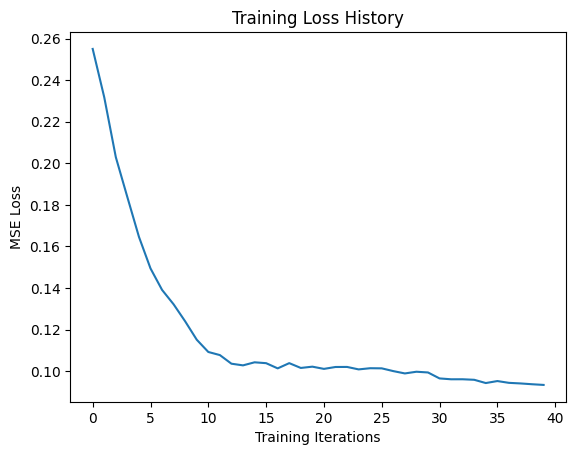

In [ ]:
'''
10.学習損失のプロット
・各エポックの平均MSE損失をプロット。
・モデルの収束具合を視覚化。
'''

plt.plot(loss_list)
plt.title('Training Loss History')
plt.xlabel('Training Iterations')
plt.ylabel('MSE Loss')

In [ ]:
'''
11.テストデータによる評価
・出力が 0.5 より大きい場合をラベル1と判定。
・損失と正解率を計算して出力。
'''

model.eval()
with torch.no_grad():
    
    correct = 0
    n_sample = 0
    output_list = []
    target_list = []
    for batch_idx, (data, target) in enumerate(test_loader):
        data = (torch.nn.AvgPool2d(3)(data)).float()
        output = model(data)
        
        pred = (output > 0.5).squeeze().int()
        correct += torch.sum(pred == target).item()
        n_sample += len(target)
        
        output_list.append(output.squeeze())
        target_list.append(target.double())

    total_output = torch.cat(output_list)
    total_target = torch.cat(target_list)
    total_loss = loss_func(total_output, total_target)
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        total_loss.item(),
        correct / n_sample * 100)
        )

Performance on test data:
	Loss: 0.0810
	Accuracy: 100.0%


In [ ]:
'''
12.学習データでの再評価
・トレーニングセットに対する損失と正解率も表示。
'''

model.eval()
with torch.no_grad():
    
    correct = 0
    n_sample = 0
    output_list = []
    target_list = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data = (torch.nn.AvgPool2d(3)(data)).float()
        output = model(data)
        
        pred = (output > 0.5).squeeze().int()
        correct += torch.sum(pred == target).item()
        n_sample += len(target)
        
        output_list.append(output.squeeze())
        target_list.append(target.double())

    total_output = torch.cat(output_list)
    total_target = torch.cat(target_list)
    total_loss = loss_func(total_output, total_target)
    print('Performance on train data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        total_loss.item(),
        correct / n_sample * 100)
        )

Performance on train data:
	Loss: 0.0942
	Accuracy: 98.0%
